<br>

# <div align="center">Finding the Optimal Location for Opening <br>a New Restaurant in South West London

## <div align="center">IBM Data Science Capstone Project

### <div align="center">Ken Young, August 2020

## Table of Contents
* [Introduction and Business Problem](#intro)
* [Data](#data)
* [Methodology](#method)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

<br>

## 1. Introduction
<a id="intro"></a>

Our client is a successful restaurant business with a long established presence in the West End and City in Central London.<br>
They have built a reputation for excellent service in the casual dining market, offering quality innovative menus blending dishes from East and South East Asia.<br>
Their recent addition of fixed price menus appealing to time-sensitive customers has proven popular. <br>This is valued, for example, by office workers on lunch breaks and diners heading to the cinema or theatre.<br>
Our client is looking to expand by opening a new restaurant in South West London.<br>
From the client's initial research, which involves limited detailed analysis, there are a number of locations that are potentially suitable. 

<br>

## 2. Business Problem

In the restaurant business, location is one of the key factors in determining whether a new venture will be profitable.<br>
The objective of this project is to identify, using data science techniques and the Foursquare location API, optimal locations for the proposed restaurant in South West London.<br>
We will analyse and compare neighbourhoods with the following factors which we believe are critical in identifying a suitable location:-<br>
- Existing restaurants particularly potential competitors in the vicinity.
- Spending power of local population.
- Proximity to transportation hubs.
- Proximity to entertainment venues such as cinemas.

<b>Audience:-</b><br>
The findings of this project will be presented to the client's senior management and we believe our analytical approach will identify suitable locations that will support the profitability and long term competitive advantage of the venture.

<br>

## 3. Data
<a id="data"></a>

To solve our business problem, we will use the following data:-<br>
- <b>List of neighbourhoods in South West London.</b><br>This defines the scope of the project.<br>As agreed with our client, this definition includes the London Boroughs of Merton, Richmond Upon Thames and Wandsworth.<br>We will use the following Wikipedia page to extract a list of neighbourhoods in the desired Borough list.<br>[List of areas of London](https://en.wikipedia.org/wiki/List_of_areas_of_London)
- <b>Latitude and Longitude data for these neighbourhoods.</b><br>This will be obtained from the Python Geocoder package and is necessary to plot maps and obtain venue data. 
- <b>Venue data, particularly cinemas and competitor restaurants.</b><br>We will use the Foursquare API and we will be using this data to perform clustering on neighbourhoods.
- <b>Locations of railway stations.</b><br>Locations close to railway stations, in particular tube stations, will generally have heavier footfall and potential customers. <br>We will use Foursquare API to obtain railway station locations.
- <b>Median household income for each neighbourhood.</b><br>As the restaurant is in the casual dining sector, information on potential disposable income is an important consideration. <br>We will use the Excel spreadsheet obtained from the following website.<br>
[Household income](https://data.london.gov.uk/dataset/household-income-estimates-small-areas)

We will now import the data we require, checking and cleaning it, then merging it into a single database.<br>This database will then be used to conduct our analysis.

### Import dependencies required for Data section

First of all we need to import a number of Python libraries to support us in getting the data we need.

In [1]:
from bs4 import BeautifulSoup #import BeautifulSoup library to extract data from web pages
import pandas as pd #import pandas library
import requests
import numpy as np
import matplotlib.cm as cm #Matplotlib and associated plotting modules
import matplotlib.colors as colors
!conda install -c conda-forge folium=0.5.0 --yes
import folium #Map rendering library
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim #Convert an address into latitude and longitude values
from geopy.extra.rate_limiter import RateLimiter

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                       

### Get list of neighbourhoods from website using BeautifulSoup

To obtain a list of neighbourhoods, we will scrape a data table from the Wikipedia page "List of areas of London".

In [2]:
#Identify Source Data and Create Dataframe using BeautifulSoup
url="https://en.wikipedia.org/wiki/List_of_areas_of_London"

In [3]:
source=requests.get(url).text

In [4]:
soup=BeautifulSoup(source,'xml')

In [5]:
table=soup.find('table',{'class':'wikitable sortable'})

Let's identify exactly where the data we need is stored in the Wikipedia table.

In [6]:
# Get first 2 columns only
headers = table.find_all('th')
headers = [th.text.strip() for th in headers]
headers = headers[:2]
x = headers[1].split('\xa0')
x = ' '.join(x)
headers.pop()
headers.append(x)
headers

['Location', 'London borough']

We just want Locations (we will rename this column as Neighbourhoods later for consistency) and Boroughs.

In [7]:
rows = []
for tr in table.find_all('tr'):
    tds = tr.find_all('td')
    rows.append(tds)
    if not tds:
        continue
del rows[0]

col_0 = []
for i in range(len(rows)):
    col_0.append(rows[i][0])
Locations = []
for location in col_0:
    Locations.append(location.text)
for index, ele in enumerate(Locations):
    if '(' in ele:
        Locations[index] = Locations[index].split('(')[0]
for index, ele in enumerate(Locations):
    if ',' in ele:
        Locations[index] = Locations[index].split(',')[0]        
    
col_1 = []
for i in range(len(rows)):
    col_1.append(rows[i][1])
Boroughs = []
for borough in col_1:
    Boroughs.append(borough.text)
for index, ele in enumerate(Boroughs):
    if '[' in ele:
        Boroughs[index] = Boroughs[index].split('[')[0]
for index, ele in enumerate(Boroughs):
    if ',' in ele:
        Boroughs[index] = Boroughs[index].split(',')[0]

Let's now convert the data we extracted into a pandas dataframe.

In [8]:
df = pd.DataFrame(list(zip(Locations, Boroughs)), 
               columns=headers) 
df.head()

,Location,London borough
0,Abbey Wood,Bexley
1,Acton,Ealing
2,Addington,Croydon
3,Addiscombe,Croydon
4,Albany Park,Bexley


### Get latitude and longitude coordinates using Geocoder

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent london_explorer, as shown below.

In [9]:
latitude = []
longitude = []
for i in range(len(Locations)):
    address = str(Locations[i]+', '+ Boroughs[i] + ', England')
    geolocator = Nominatim(user_agent="london_explorer")
    location = geolocator.geocode(address)
    try: 
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    except:
        latitude.append("Not Found")
        longitude.append("Not Found")

In [10]:
headers.append('Latitude')
headers.append('Longitude')
if len(headers)>4:
    headers = headers[:4]

Add coordinates to our dataframe

In [11]:
df=pd.DataFrame(list(zip(Locations,Boroughs,latitude,longitude)), 
               columns=headers) 
df.head()

,Location,London borough,Latitude,Longitude
0,Abbey Wood,Bexley,51.49,0.132891
1,Acton,Ealing,51.5081,-0.273261
2,Addington,Croydon,51.3586,-0.0316347
3,Addiscombe,Croydon,51.3797,-0.0742821
4,Albany Park,Bexley,51.4354,0.125965


At present, our dataset includes ALL London neighbourhoods. We just want neighbourhoods from 3 London boroughs.<br>Let's now correct the dataset.

In [12]:
#Reduce dataset so that it only contains London Boroughs of Merton, Richmond Upon Thames and Wandsworth
new_df = df[df['London borough'].isin(['Merton', 'Richmond upon Thames', 'Wandsworth'])].copy()
new_df.head()

,Location,London borough,Latitude,Longitude
16,Balham,Wandsworth,51.4456,-0.150364
22,Barnes,Richmond upon Thames,51.4719,-0.238744
27,Battersea,Wandsworth,51.4708,-0.172214
82,Castelnau,Richmond upon Thames,51.4874,-0.231228
107,Colliers Wood,Merton,51.4183,-0.177863


### Get household income data from website using csv upload

Let's now turn to household income data per neighbourhood. We've downloaded the Excel file from the website.<br>We will now convert the file into csv format and use the pandas.read_csv function to create a new dataset.

In [13]:
# load household income of each London neighbourhood
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

#client id removed for sharing

# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_income = pd.read_csv(body)
df_income.head()

,Location,Median_Household_Inc
0,Colliers Wood,38780
1,Lower Morden,38730
2,Merton Park,46300
3,Mitcham,38730
4,Morden,38730


### Merge databases

We will now merge the 2 databases created above and name the combined database as 'neighbourhoods'.

In [14]:
neighbourhoods = pd.merge(new_df, df_income, on='Location', how='left').reset_index(drop=True)
#Check merged Dataframe is correct
neighbourhoods.head()

,Location,London borough,Latitude,Longitude,Median_Household_Inc
0,Balham,Wandsworth,51.4456,-0.150364,53420.0
1,Barnes,Richmond upon Thames,51.4719,-0.238744,55450.0
2,Battersea,Wandsworth,51.4708,-0.172214,55380.0
3,Castelnau,Richmond upon Thames,51.4874,-0.231228,NaN
4,Colliers Wood,Merton,51.4183,-0.177863,38780.0


### Tidy up merged database and check for missing data

We will now perform checks to ensure the integrity of our database.

In [15]:
#Dataframe shape check.
neighbourhoods.shape

(39, 5)

The dataframe should contain 39 rows and 5 columns. Our dataframe is the correct size.

Let's rename the column headers to ensure consistency across the project.

In [16]:
neighbourhoods.rename({'Location':'Neighbourhood','London borough':'Borough','Median_Household_Inc':'Median Household Inc'},axis=1,inplace=True)
neighbourhoods.head()

,Neighbourhood,Borough,Latitude,Longitude,Median Household Inc
0,Balham,Wandsworth,51.4456,-0.150364,53420.0
1,Barnes,Richmond upon Thames,51.4719,-0.238744,55450.0
2,Battersea,Wandsworth,51.4708,-0.172214,55380.0
3,Castelnau,Richmond upon Thames,51.4874,-0.231228,NaN
4,Colliers Wood,Merton,51.4183,-0.177863,38780.0


We will now check for missing values.

In [17]:
missing_data=neighbourhoods.isnull()

In [18]:
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print(" ")

Neighbourhood
False    39
Name: Neighbourhood, dtype: int64
 
Borough
False    39
Name: Borough, dtype: int64
 
Latitude
False    39
Name: Latitude, dtype: int64
 
Longitude
False    39
Name: Longitude, dtype: int64
 
Median Household Inc
False    38
True      1
Name: Median Household Inc, dtype: int64
 


The above check indicates that there is 1 missing value from the Median Household Income column.

From investigations, Median Household Income for Castlenau is missing. <br>In the original database Castlenau has the same recorded income as Barnes. <br>We will replace NaN with the correct value, 55450.

In [19]:
neighbourhoods.fillna(value=55450,inplace=True)

The dataset is now complete and is ready for exploratory data analysis. Let's save a copy to csv.

In [20]:
#Save dataset to csv
neighbourhoods.to_csv("neighbourhoods.csv",index=False)

### Use geopy library to get the latitude and longitude values of South West London.

As London is a geographically large area, we will select a neighbourhood from our dataset as a reasonably central point for South West London.

In [21]:
address = 'Roehampton, London, England'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('A central point for coordinates of South West London are {}, {}.'.format(latitude, longitude))

A central point for coordinates of South West London are 51.4498773, -0.2412672.


OK now we have our coordinates as a centre point for our London boroughs of interest.

### Create a map of South West London with neighbourhoods superimposed on top.

Let's now look at our neighbourhoods on the map.

In [22]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighbourhood in zip(neighbourhoods['Latitude'], neighbourhoods['Longitude'], neighbourhoods['Borough'], neighbourhoods['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

### Explore neighbourhoods using Foursquare API

Now we turn to Foursquare to get the venue detail and locations we will need for analysis.<br>We will first of all define Foursquare Credentials and Version

In [23]:
CLIENT_ID = #id removed for sharing # your Foursquare ID
CLIENT_SECRET = #id removed for sharing # your Foursquare Secret
VERSION = #id removed for sharing # Foursquare API version

Let's explore venues around the first neighbourhood in our database to visualise the data available.

In [24]:
#Obtain 1st row from our Dataframe
neighbourhoods.loc[0, 'Neighbourhood']

'Balham'

In [25]:
#Get the 1st rows latitude and longitude
neighborhood_latitude = neighbourhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighbourhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighbourhoods.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Balham are 51.4456449, -0.1503643.


Let's see what the top 100 venues are within 1000m of our test location from our database.

In [26]:
#Get the top 100 venues within 1000m of Balham
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f296e702378a6144b8fae68'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Balham',
  'headerFullLocation': 'Balham, London',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 86,
  'suggestedBounds': {'ne': {'lat': 51.45464490900001,
    'lng': -0.13595097151542923},
   'sw': {'lat': 51.436644890999986, 'lng': -0.16477762848457078}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '53e60df6498ed3877e335a24',
       'name': 'We Brought Beer',
       'location': {'address': '28 Hildreth St',
        'lat': 51.44432378531036,
        'lng': -0.1506561166853583,
        'labeledLatLngs': [{'label': 'display',
          'lat': 51.4443

In [27]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We will clean our json and structure it into a pandas dataframe.

In [28]:
#Clean the json and structure it into a pandas dataframe
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,We Brought Beer,Beer Store,51.444324,-0.150656
1,M1LK,Coffee Shop,51.444450,-0.150913
2,Franco Manca,Pizza Place,51.443616,-0.149959
3,Brickwood Coffee & Bread,Coffee Shop,51.444509,-0.151127
4,Ciullosteria,Italian Restaurant,51.447144,-0.148981


Check number of venues returned by Foursquare.

In [29]:
#Number of venues returned by Foursquare
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

86 venues were returned by Foursquare.


OK we have now completed our data stage of the project. We have imported what we need and have explored the data to get a good idea of what is available.<br>We are now ready to discuss our Methodology for our analysis stage of the project.

<br>

## 4. Methodology
<a id="method"></a>

In this project we will focus our efforts in identifying neighbourhoods of South West London that have higher household income and some existing potential competitor restaurants.
Our logic is that higher household income areas are more likely to have disposable income to spend in restaurants.
Using median household income doesn't of course tell us anything about distribution of income, but we believe it is a good starting point to build up a picture of the local customer base.
For competitor restaurants we believe that a large number of existing venues may prove very difficult for a new restaurant to get a foothold in the market.
At the opposite end, a lack of competitors may mean there is little demand in the area. Therefore our ideal is somewhere in the middle.

In our Data section we also specified data gathering on train stations and other venues likely to create significant footfall such as cinemas.
From exploratory data analysis, it is clear that most parts of South West London are well served by train stations. It is probably more of interest to identify the few areas which don't have close access to a train station. Therefore we believe there is little value in conducting data analysis including train station data at this stage.
For cinemas etc., much of South West London is suburban with centres of commerce of various sizes in each neighbourhood. Although our client gets a sizeable amount of customers in its existing central London restaurants from pre/post cinema/theatre traffic, there aren't many venues of this nature in our target area. Our assumption is that customers will likely be a mix of locals who live/work in the area and those who commute by train to central London.  

Our first step is to gather venue information from Foursquare for our neighbourhoods. We will limit our data gathering to the top 100 venues within 1km of each neighbourhood, for simplicity. We will use one-hot encoding to prepare the data for subsequent machine learning algorithms.

Our second step is to amalgamate the various categories of restaurants which are likely to be competitors. As our client offers a selection of dishes combining cuisines around East and South East Asia, we will sum restaurants categorised as Thai, Korean, Japanese, Chinese amongst others. Foursquare also uses the category Asian which appears to be a general term for the above. From data analysis this category will also be added to our summation. 

Our third step is to visualise our 2 main criteria; competitor restaurants and household income.
From our updated database, we will plot a bar chart visualising the total number of Asian restaurants per neighbourhood.
We will also plot a bar chart visualising median household income per neighbourhood.

Our fourth and final step is to create clusters of neighbourhoods with similar characteristics. We normalise our dataset using Standard Scaler, then use the squared error technique to identify the number of clusters to use. We then fit our dataset into our clustering algorithm using the k-means technique.
The most favourable potential locations will be in the cluster with higher household income and a medium level of existing competitors. Neighbourhoods in this cluster can then be explored by the client in more detail. 

<br>

## 5. Analysis
<a id="analysis"></a>

### Get top 100 venues within 1000m of our neighbourhoods in South West London

Extract venue data for each neighbourhood using Foursquare.

In [30]:
import requests
LIMIT = 100
radius = 1000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT
    )

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
  venues_list = []
  for name, lat, lng in zip(names, latitudes, longitudes):
    print(name)

    #create the API request url
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT
    )

    # make the GET request
    results = requests.get(url).json()['response']['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    venues_list.append([(
        name,
        lat,
        lng,
        v['venue']['name'],
        v['venue']['location']['lat'],
        v['venue']['location']['lng'],
        v['venue']['categories'][0]['name']) for v in results
        ])
  
  nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
  nearby_venues.columns = ['Neighbourhood',
                           'Neighbourhood Latitude',
                           'Neighbourhood Longitude',
                           'Venue',
                           'Venue Latitude',
                           'Venue Longitude',
                           'Venue Category']

  return(nearby_venues)

Create new dataframe for the Foursquare data extracted above.

In [31]:
#Function using code above to create new Dataframe
swlondon_venues = getNearbyVenues(names=neighbourhoods['Neighbourhood'],
                                   latitudes=neighbourhoods['Latitude'],
                                   longitudes=neighbourhoods['Longitude']
                                  )

Balham
Barnes
Battersea
Castelnau
Colliers Wood
Earlsfield
East Sheen
Eel Pie Island
Fulwell
Ham
Hampton
Hampton Hill
Hampton Wick
Kew
Lower Morden
Merton Park
Mitcham
Morden
Morden Park
Mortlake
Nine Elms
North Sheen
Petersham
Putney
Raynes Park
Richmond
Roehampton
South Wimbledon
Southfields
St Helier
St Margarets
Strawberry Hill
Teddington
Tooting
Tooting Bec
Twickenham
Wandsworth
Whitton
Wimbledon


Check size, venues and unique categories for new dataframe.

In [32]:
#check size of new dataframe
print(swlondon_venues.shape)
swlondon_venues.head()

(2078, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Balham,51.445645,-0.150364,We Brought Beer,51.444324,-0.150656,Beer Store
1,Balham,51.445645,-0.150364,M1LK,51.444450,-0.150913,Coffee Shop
2,Balham,51.445645,-0.150364,Franco Manca,51.443616,-0.149959,Pizza Place
3,Balham,51.445645,-0.150364,Brickwood Coffee & Bread,51.444509,-0.151127,Coffee Shop
4,Balham,51.445645,-0.150364,Ciullosteria,51.447144,-0.148981,Italian Restaurant


In [33]:
#how many venues for each neighborhood
swlondon_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Balham,86,86,86,86,86,86
Barnes,50,50,50,50,50,50
Battersea,100,100,100,100,100,100
Castelnau,100,100,100,100,100,100
Colliers Wood,27,27,27,27,27,27
Earlsfield,71,71,71,71,71,71
East Sheen,29,29,29,29,29,29
Eel Pie Island,67,67,67,67,67,67
Fulwell,36,36,36,36,36,36


In [34]:
#how many unique categories from returned venues
print('There are {} unique categories.'.format(len(swlondon_venues['Venue Category'].unique())))

There are 216 unique categories.


### Analyse each South West London neighbourhood

We will now analyse each neighbourhood using one hot encoding.

In [35]:
#analyse each neighborhood
# one hot encoding
swlondon_onehot = pd.get_dummies(swlondon_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood location column back to dataframe
swlondon_onehot['Neighbourhood'] = swlondon_venues['Neighbourhood'] 

# move neighborhood location column to the first column
fixed_columns = [swlondon_onehot.columns[-1]] + list(swlondon_onehot.columns[:-1])
swlondon_onehot = swlondon_onehot[fixed_columns]

swlondon_onehot.head()

,Neighbourhood,American Restaurant,Animal Shelter,Antique Shop,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,...,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Balham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Balham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Balham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Balham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Balham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
#new dataframe size
swlondon_onehot.shape

(2078, 217)

We will now analyse how many venues of interest - Asian Restaurants, Thai, Japanese etc. Restaurants, Cinemas, Train Stations - are in each neighbourhood.

In [37]:
df_venues = pd.DataFrame(data={'Neighbourhood': swlondon_onehot['Neighbourhood'],'Asian Restaurants':swlondon_onehot['Asian Restaurant'],
                              'Thai Restaurants':swlondon_onehot['Thai Restaurant'], 'Japanese Restaurants':swlondon_onehot['Japanese Restaurant'],
                              'Vietnamese Restaurants':swlondon_onehot['Vietnamese Restaurant'], 'Korean Restaurants':swlondon_onehot['Korean Restaurant'],
                              'Chinese Restaurants':swlondon_onehot['Chinese Restaurant'], 
                              'Train Stations':swlondon_onehot['Train Station'], 'Metro Stations':swlondon_onehot['Metro Station'],
                              'Cinemas':swlondon_onehot['Movie Theater']})
venues_grouped = df_venues.groupby('Neighbourhood').sum().reset_index()
venues_grouped

,Neighbourhood,Asian Restaurants,Thai Restaurants,Japanese Restaurants,Vietnamese Restaurants,Korean Restaurants,Chinese Restaurants,Train Stations,Metro Stations,Cinemas
0,Balham,1,0,1,0,0,0,1,1,0
1,Barnes,0,1,0,0,0,0,1,0,1
2,Battersea,1,1,2,2,0,0,2,0,0
3,Castelnau,1,3,2,2,0,0,0,0,0
4,Colliers Wood,0,1,0,0,0,0,0,0,0
5,Earlsfield,1,3,0,0,0,0,0,0,0
6,East Sheen,0,0,0,0,0,0,0,0,0
7,Eel Pie Island,0,0,1,1,0,0,0,0,0
8,Fulwell,0,0,0,0,0,1,1,0,0
9,Ham,0,0,0,0,0,0,0,0,0


We will combine the Restaurant categories above into 1 column for East & South East Asia for our analysis purposes.<br>
Also as expected, the 3 boroughs do not have many cinemas and as discussed in our Methodology, won't be used in clustering analysis.<br>
Our boroughs are in general well served by train stations. Although a neighbourhood would be notable if it doesn't have a station<br>
i.e. (would not be a suitable candidate area for a restaurant), we will not use train station data in clustering analysis.

Let's create a temporary dataset combining the East & South East Asian restaurant categories into one column.

In [38]:
total_asian_rest = swlondon_onehot['Asian Restaurant']+swlondon_onehot['Thai Restaurant']+swlondon_onehot['Japanese Restaurant']+\
                   swlondon_onehot['Vietnamese Restaurant']+swlondon_onehot['Korean Restaurant']+swlondon_onehot['Chinese Restaurant']
df_totalasian = pd.DataFrame(data={'Neighbourhood': swlondon_onehot['Neighbourhood'],'Total Asian Restaurants':total_asian_rest})
df_totalasian = df_totalasian.groupby('Neighbourhood').sum().reset_index()
df_totalasian.head()

,Neighbourhood,Total Asian Restaurants
0,Balham,2
1,Barnes,1
2,Battersea,6
3,Castelnau,8
4,Colliers Wood,1


We've now created a new database which includes a total column for our competitor restaurants.

We will now merge this database into our main working dataset.

In [39]:
# Merge Total Asian Restaurant column into working dataset
swlondon_onehot1 = pd.merge(df_totalasian,swlondon_onehot,on='Neighbourhood')
#We no longer need the individual Asian restaurant categories, we will drop these columns
swlondon_onehot2 = swlondon_onehot1.drop(['Asian Restaurant','Thai Restaurant','Japanese Restaurant',
                                        'Vietnamese Restaurant','Korean Restaurant','Chinese Restaurant'],axis=1)

In [40]:
#confirm new dataframe size
swlondon_onehot2.shape

(2078, 212)

This is correct as we've added 1 new column and removed 6 columns.

### Group rows by neighbourhood and take mean frequency of Asian restaurants

In [41]:
swlondon_grouped = swlondon_onehot2.groupby('Neighbourhood').mean().reset_index()
swlondon_grouped = swlondon_grouped[['Neighbourhood', 'Total Asian Restaurants']]
swlondon_grouped.set_index('Neighbourhood', inplace=True)

### Visualise by plotting a frequency distribution chart of Asian restaurants

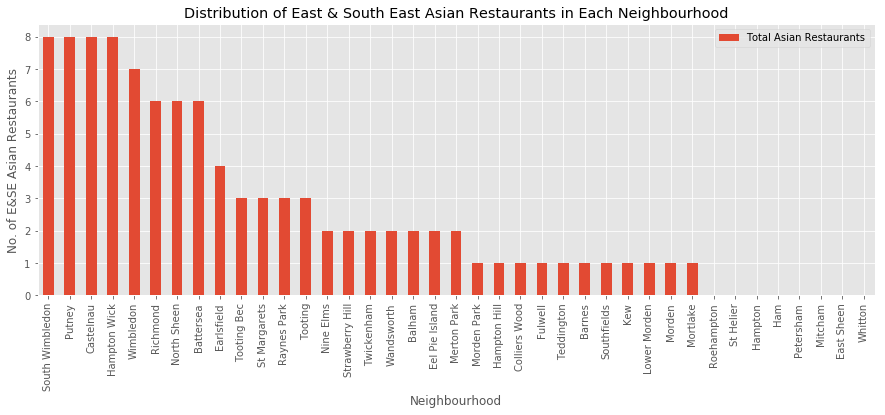

In [42]:
# sort by descending order
swlondon_grouped.sort_values(by='Total Asian Restaurants', ascending=False, inplace=True)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')
swlondon_grouped.plot(kind='bar', figsize=(15,5))

plt.title('Distribution of East & South East Asian Restaurants in Each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('No. of E&SE Asian Restaurants')

plt.show()

### Visualise by plotting a distribution of median household incomes in each neighbourhood

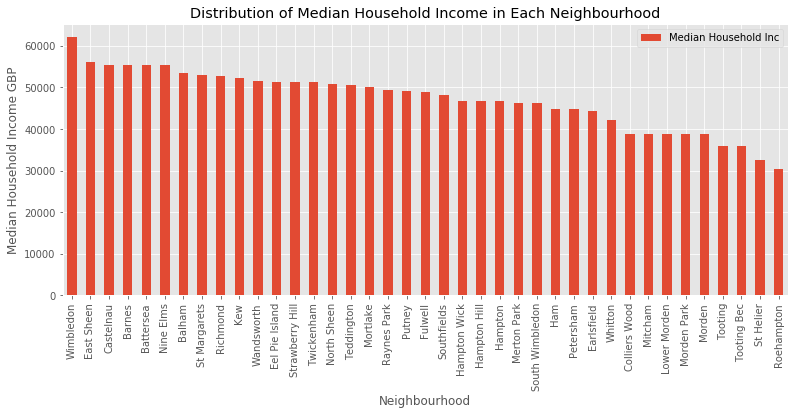

In [43]:
income_dist = neighbourhoods[['Neighbourhood', 'Median Household Inc']].set_index('Neighbourhood')

# sort by descending order
income_dist.sort_values(by='Median Household Inc', ascending=False, inplace=True)

#plot bar graph
income_dist.plot(kind='bar', figsize=(13,5))
plt.title('Distribution of Median Household Income in Each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Median Household Income GBP')

plt.show()

### Create dataframe for clustering

In [44]:
# merge neighbourhoods with swlondon_grouped
df_final = pd.merge(neighbourhoods, swlondon_grouped, on='Neighbourhood')

Let's check the first few rows of data.

In [91]:
df_final.head()

,Neighbourhood,Borough,Latitude,Longitude,Median Household Inc,Total Asian Restaurants
0,Balham,Wandsworth,51.445645,-0.150364,53420.0,2.0
1,Barnes,Richmond upon Thames,51.471896,-0.238744,55450.0,1.0
2,Battersea,Wandsworth,51.470793,-0.172214,55380.0,6.0
3,Castelnau,Richmond upon Thames,51.487429,-0.231228,55450.0,8.0
4,Colliers Wood,Merton,51.418275,-0.177863,38780.0,1.0


### Cluster neighbourhoods

We first of all need to normalise our dataset. We will use StandardScaler()

In [92]:
from sklearn.preprocessing import StandardScaler
X = df_final.values[:,4:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.87397422, -0.19948202],
       [ 1.15969309, -0.58847196],
       [ 1.14984071,  1.35647773],
       [ 1.15969309,  2.13445761],
       [-1.18657961, -0.58847196],
       [-0.40120458,  0.57849786],
       [ 1.24977195, -0.97746189],
       [ 0.58684787, -0.19948202],
       [ 0.22512496, -0.58847196],
       [-0.329423  , -0.97746189],
       [-0.06481636, -0.97746189],
       [-0.06481636, -0.58847196],
       [-0.06340887,  2.13445761],
       [ 0.69240903, -0.58847196],
       [-1.19361702, -0.58847196],
       [-0.12815305, -0.19948202],
       [-1.19361702, -0.97746189],
       [-1.19361702, -0.58847196],
       [-1.19361702, -0.58847196],
       [ 0.40669015, -0.58847196],
       [ 1.14984071, -0.19948202],
       [ 0.5136588 ,  1.35647773],
       [-0.329423  , -0.97746189],
       [ 0.2532746 ,  2.13445761],
       [ 0.29972151,  0.18950792],
       [ 0.77122802,  1.35647773],
       [-2.37730948, -0.97746189],
       [-0.12815305,  2.13445761],
       [ 0.13363862,

We will convert our cluster array into a pandas dataframe.

In [93]:
df_normalised = pd.DataFrame(Clus_dataSet)
df_normalised.rename(columns={0:'Household Income', 1:'No. of Asian Restaurants'}, inplace=True)
df_normalised.head()

,Household Income,No. of Asian Restaurants
0,0.873974,-0.199482
1,1.159693,-0.588472
2,1.149841,1.356478
3,1.159693,2.134458
4,-1.186580,-0.588472


### Find optimal number of clusters, k

Before we can fit the values above into our cluster model, we have to pre-assign the number of clusters, k, to be used.<br>We will use the Squared Error method to assess the performance of each potential number of clusters.

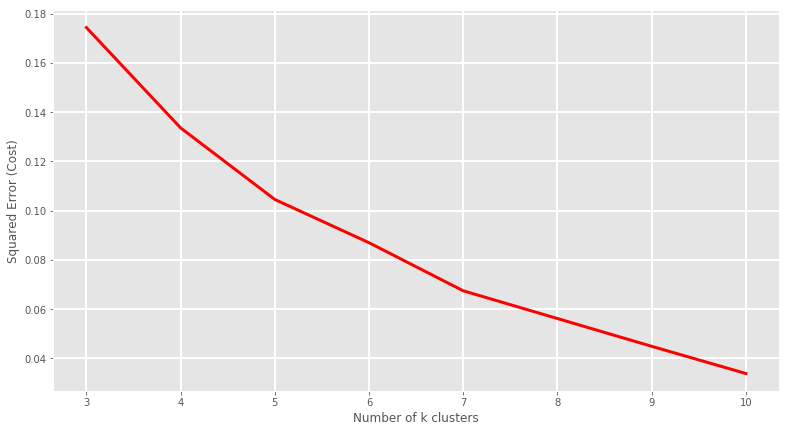

In [94]:
from sklearn.cluster import KMeans

error_cost=[]

for i in range(3, 11):
  KM = KMeans(n_clusters=i, max_iter=100)
  try:
    KM.fit(df_normalised)

  except ValueError:
    print('Error on line', i)

  # calculate squared error for the clustered points
  error_cost.append(KM.inertia_ / 100)

# plot the K values against the squared error cost
plt.figure(figsize=(13,7))
plt.plot(range(3,11), error_cost, color='r', linewidth=3)
plt.xlabel('Number of k clusters')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)

plt.show()

The curve appears less steep from k=5 and k=7. From trial and error, we establish that k=6 appears to be the best fit.

### Clustering South West London neighbourhoods with k-means, k=6

In [95]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_normalised)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 4, 5, 5, 1, 0, 4, 4, 3, 3], dtype=int32)

Create new dataframe which includes the clustering. Drop the income column as this isn't needed.

In [96]:
df_normalised.drop(['Household Income'], axis=1, inplace=True)
df_clustered = pd.merge(neighbourhoods, df_normalised, left_index=True, right_index=True)
df_clustered.insert(0, 'Cluster Label', kmeans.labels_)
df_clustered.head()

,Cluster Label,Neighbourhood,Borough,Latitude,Longitude,Median Household Inc,No. of Asian Restaurants
0,4,Balham,Wandsworth,51.445645,-0.150364,53420.0,-0.199482
1,4,Barnes,Richmond upon Thames,51.471896,-0.238744,55450.0,-0.588472
2,5,Battersea,Wandsworth,51.470793,-0.172214,55380.0,1.356478
3,5,Castelnau,Richmond upon Thames,51.487429,-0.231228,55450.0,2.134458
4,1,Colliers Wood,Merton,51.418275,-0.177863,38780.0,-0.588472


### Visualise clusters on map

In [103]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude,longitude], zoom_start=12)

# set color schemes for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_clustered['Latitude'], df_clustered['Longitude'], df_clustered['Neighbourhood'], df_clustered['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1.0).add_to(map_clusters)
       
map_clusters

### Examine clusters

Let's now examine each of our 6 clusters. We can summarise the relative merits of each cluster as suitable locations for opening a restaurant.

#### Cluster 0

In [104]:
df_clustered.loc[df_clustered['Cluster Label'] == 0]

,Cluster Label,Neighbourhood,Borough,Latitude,Longitude,Median Household Inc,No. of Asian Restaurants
5,0,Earlsfield,Wandsworth,51.446448,-0.189394,44360.0,0.578498
15,0,Merton Park,Merton,51.407994,-0.201965,46300.0,-0.199482
24,0,Raynes Park,Merton,51.408966,-0.230540,49340.0,0.189508


#### Cluster 1

In [105]:
df_clustered.loc[df_clustered['Cluster Label'] == 1]

,Cluster Label,Neighbourhood,Borough,Latitude,Longitude,Median Household Inc,No. of Asian Restaurants
4,1,Colliers Wood,Merton,51.418275,-0.177863,38780.0,-0.588472
14,1,Lower Morden,Merton,51.389774,-0.216363,38730.0,-0.588472
16,1,Mitcham,Merton,51.405801,-0.164079,38730.0,-0.977462
17,1,Morden,Merton,51.402761,-0.194755,38730.0,-0.588472
18,1,Morden Park,Merton,51.391337,-0.210663,38730.0,-0.588472
26,1,Roehampton,Wandsworth,51.449877,-0.241267,30320.0,-0.977462
29,1,St Helier,Merton,51.389461,-0.198921,32530.0,-0.977462
33,1,Tooting,Wandsworth,51.426659,-0.169077,36000.0,0.189508
34,1,Tooting Bec,Wandsworth,51.435609,-0.159655,36000.0,0.189508


#### Cluster 2

In [106]:
df_clustered.loc[df_clustered['Cluster Label'] == 2]

,Cluster Label,Neighbourhood,Borough,Latitude,Longitude,Median Household Inc,No. of Asian Restaurants
12,2,Hampton Wick,Richmond upon Thames,51.414452,-0.312674,46760.0,2.134458
23,2,Putney,Wandsworth,51.460934,-0.215348,49010.0,2.134458
27,2,South Wimbledon,Merton,51.415176,-0.192646,46300.0,2.134458


#### Cluster 3

In [107]:
df_clustered.loc[df_clustered['Cluster Label'] == 3]

,Cluster Label,Neighbourhood,Borough,Latitude,Longitude,Median Household Inc,No. of Asian Restaurants
8,3,Fulwell,Richmond upon Thames,51.433748,-0.349685,48810.0,-0.588472
9,3,Ham,Richmond upon Thames,51.434764,-0.309299,44870.0,-0.977462
10,3,Hampton,Richmond upon Thames,51.415027,-0.369141,46750.0,-0.977462
11,3,Hampton Hill,Richmond upon Thames,51.427844,-0.355081,46750.0,-0.588472
22,3,Petersham,Richmond upon Thames,51.443691,-0.305293,44870.0,-0.977462
28,3,Southfields,Wandsworth,51.445775,-0.206614,48160.0,-0.588472
37,3,Whitton,Richmond upon Thames,51.451169,-0.357976,42230.0,-0.977462


#### Cluster 4

In [108]:
df_clustered.loc[df_clustered['Cluster Label'] == 4]

,Cluster Label,Neighbourhood,Borough,Latitude,Longitude,Median Household Inc,No. of Asian Restaurants
0,4,Balham,Wandsworth,51.445645,-0.150364,53420.0,-0.199482
1,4,Barnes,Richmond upon Thames,51.471896,-0.238744,55450.0,-0.588472
6,4,East Sheen,Richmond upon Thames,51.462371,-0.267094,56090.0,-0.977462
7,4,Eel Pie Island,Richmond upon Thames,51.445126,-0.325408,51380.0,-0.199482
13,4,Kew,Richmond upon Thames,51.480663,-0.291929,52130.0,-0.588472
19,4,Mortlake,Richmond upon Thames,51.468069,-0.266940,50100.0,-0.588472
20,4,Nine Elms,Wandsworth,51.478743,-0.136263,55380.0,-0.199482
30,4,St Margarets,Richmond upon Thames,51.456709,-0.322412,52870.0,0.189508
31,4,Strawberry Hill,Richmond upon Thames,51.438592,-0.339937,51380.0,-0.199482
32,4,Teddington,Richmond upon Thames,51.427784,-0.333653,50600.0,-0.588472


#### Cluster 5

In [109]:
df_clustered.loc[df_clustered['Cluster Label'] == 5]

,Cluster Label,Neighbourhood,Borough,Latitude,Longitude,Median Household Inc,No. of Asian Restaurants
2,5,Battersea,Wandsworth,51.470793,-0.172214,55380.0,1.356478
3,5,Castelnau,Richmond upon Thames,51.487429,-0.231228,55450.0,2.134458
21,5,North Sheen,Richmond upon Thames,51.465325,-0.286582,50860.0,1.356478
25,5,Richmond,Richmond upon Thames,51.463207,-0.300413,52690.0,1.356478
38,5,Wimbledon,Merton,51.422072,-0.205290,62200.0,1.745468


<br>

## 6. Results and Discussion
<a id="results"></a>

We observe the following results from our clustering algorithm.
Cluster 0
Mid Income, Mid number of competitors.
Cluster 1
Lower income, Lower number of competitors.
Cluster 2
Mid income, Higher number of competitors.
Cluster 3
Mid income, Lower number of competitors.
Cluster 4
Higher income, Mid number of competitors.
Cluster 5
Higher income, Higher number of competitors.

To reduce our potential list of suitable neighbourhoods significantly, we can clearly eliminate cluster 1.
Areas with lower disposable income and few (or lack of) competitors are not of interest to us.

The cluster most likely to interest us is cluster 4 with higher income and a mid number of competitors. These neighbourhoods are more likely to have households with the disposable income to spend in our client's restaurant. Also the presence of some Asian restaurants indicates there is already demand, but not too many restaurants likely to create a barrier to entry. 

Looking at the other clusters, cluster 5 has the highest income and a higher number of competitors. The higher number of competitors may suggest difficulty in opening yet another restaurant offering Asian cuisine. It is of course impossible to tell from data analysis whether or not there is potential for more restaurants to successfully open in these neighbourhoods. Our belief is cluster 5 shouldn't be the first choice of areas for consideration.
Clusters 0, 2 and 3 don't offer our optimal blend of income and competitors and are therefore not candidates for recommended areas.

Further to the above, we recommend our client considers neighbourhoods in cluster 4 for further consideration as they offer the optimum blend of potential customers disposable income and number of existing competitor restaurants.
From exploratory data analysis we gathered data on other venues likely to create footfall near our potential restaurant. Neighbourhoods such as Balham and Wandsworth are well connected by train to central London with high populations of young professionals. Kew is connected by London Underground train and also has the major tourist draw of Kew Gardens. Neighbourhoods such as Twickenham and Raynes Park are much further out from central London but are still well connected by train and are popular with commuters and families. Each of these neighbourhoods will likely have a different mix of potential customers.
It is also worth noting that the neighbourhood Nine Elms is a large redevelopment zone with many new apartments being built, a new tube station soon to open, and major employers such as the US Embassy have recently relocated there. This could indicate potential for future growth.

We'd recommend as a next step, further analysis of potential customers in the neighbourhoods listed in cluster 4. One potential source of useful information could be from official demographics data.
The client's existing restaurants in central London have a mix of after work dinner, pre/post theatre and tourist traffic. The further we move into suburban South West London, the more likely this mix will change. We'd recommend the client considers this when undertaking further research of neighbourhoods.

<br>

## 7. Conclusion
<a id="conclusion"></a>

The objective of this project was to identify areas in three South West London boroughs - Merton, Richmond, Wandsworth - potentially suitable for the opening of a new restaurant offering East and South East Asian cuisine. We selected median household income and number of existing competitor restaurants as key criteria in making this assessment. We used Foursquare to gather venue information for each neighbourhood in the three boroughs.
We then used a clustering algorithm to narrow down areas of specific interest based on our criteria, with a preference for areas that have higher household income and medium number of competitors.
We discussed how neighbourhoods closer to central London such as Nine Elms, Balham and Wandsworth (Town) are likely to have a different potential mix of customers to neighbourhoods further out into South West London such as Raynes Park, Kew and Twickenham. We'd recommend further analysis taking into account demographics of these areas.

The final decision on the optimal restaurant location and whether to consider further demographic analysis will be made by the client.
There are many additional factors involved in choosing a suitable location such as real estate availability, rental prices and business rates, proximity to areas with high footfall. We believe the analysis conducted here provides a solid starting point listing neighbourhoods worthy of further investigation.